In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames, default_sphere
from dipy.direction import DeterministicMaximumDirectionGetter
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
from dipy.io.streamline import save_trk
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response_ssst)
from dipy.reconst.dti import fractional_anisotropy, TensorModel
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import (ActStoppingCriterion,
                                              BinaryStoppingCriterion,
                                              ThresholdStoppingCriterion)
from dipy.viz import window, actor, colormap, has_fury


# Enables/disables interactive visualization
interactive = False

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')
_, _, f_pve_wm = get_fnames('stanford_pve_maps')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

white_matter = load_nifti_data(f_pve_wm)

seed_mask = (labels == 2)
seed_mask[white_matter < 0.5] = 0
seeds = utils.seeds_from_mask(seed_mask, affine, density=2)

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
csd_fit = csd_model.fit(data, mask=white_matter)

dg = DeterministicMaximumDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                      max_angle=30.,
                                                      sphere=default_sphere)

In [2]:
tensor_model = TensorModel(gtab)
tenfit = tensor_model.fit(data, mask=labels > 0)
FA = fractional_anisotropy(tenfit.evals)

threshold_criterion = ThresholdStoppingCriterion(FA, .2)

In [3]:
streamline_generator = LocalTracking(dg,
                                     threshold_criterion,
                                     seeds,
                                     affine,
                                     step_size=1,
                                     return_all=True)
streamlines = Streamlines(streamline_generator)
#sft = StatefulTractogram(streamlines, hardi_img, Space.RASMM)
#save_trk(sft, "tractogram_probabilistic_thresh_all.trk")

In [4]:
streamlines

ArraySequence([array([[ -5.46250142, -38.75908845,   5.41959979],
       [ -4.5       , -38.5       ,   5.5       ],
       [ -3.53749858, -38.24091155,   5.58040021],
       [ -2.57499716, -37.98182311,   5.66080042],
       [ -1.58800768, -37.85785566,   5.76319107],
       [ -0.60101821, -37.7338882 ,   5.86558171],
       [  0.39816967, -37.69533075,   5.85388116]]), array([[ -4.46250142, -38.75908845,   5.41959979],
       [ -3.5       , -38.5       ,   5.5       ],
       [ -2.53749858, -38.24091155,   5.58040021],
       [ -1.5505091 , -38.1169441 ,   5.68279085],
       [ -0.56351963, -37.99297665,   5.7851815 ],
       [  0.43566825, -37.9544192 ,   5.77348095]]), array([[-27.99553184, -46.37492397,   1.39705033],
       [-27.19459016, -45.84251797,   1.67097783],
       [-26.38618245, -45.27103484,   1.81198852],
       [-25.58524077, -44.73862884,   2.08591602],
       [-24.78429909, -44.20622284,   2.35984352],
       [-23.98335741, -43.67381684,   2.63377101],
       [-23.

In [5]:
print(threshold_criterion.get())

AttributeError: 'dipy.tracking.stopping_criterion.ThresholdStopping' object has no attribute 'get'

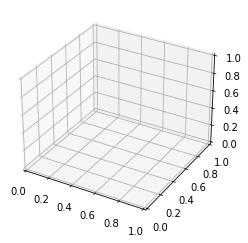

In [6]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

NameError: name 'get_points' is not defined

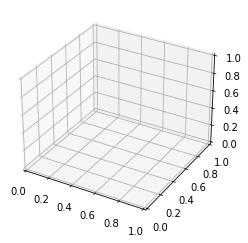

In [7]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')
for stream in streamlines:
    x,y,z=get_points(stream)
    ax.plot(x,y,z)
plt.show()

In [ ]:
type(streamlines)

In [8]:
def get_points(array):
    x=[]
    y=[]
    z=[]
    for i in array:
        x.append(i[0])
        y.append(i[1])
        z.append(i[2])
    return np.array(x),np.array(y),np.array(z)

In [9]:
from nibabel.streamlines import ArraySequence

In [10]:
def get_max_point_and_min_point(streamlines):
    max_x=0
    max_y=0
    max_z=0
    min_x=0
    min_y=0
    min_z=0
    for stream in streamlines:
        for point in stream:
            if(point[0]>max_x):
                max_x=point[0]
            if(point[1]>max_y):
                max_y=point[1]
            if(point[2]>max_z):
                max_z=point[2]
            if(point[0]<min_x):
                min_x=point[0]
            if(point[1]<min_y):
                min_y=point[1]
            if(point[0]<min_z):
                min_z=point[2]
    return ([max_x,max_y,max_z],[min_x,min_y,min_z])

In [11]:
point=get_max_point_and_min_point(streamlines)

In [12]:
point

([63.348167134274945, 67.03252137489085, 72.47387382009939],
 [-58.973879111728664, -96.10674051159612, 25.287098523554178])

In [13]:
def sum_array_in_matrix(array, sum_array):
    new_array=np.zeros_like(array)
    for i in range(array.shape[0]):
        new_array[i,:]=array[i,:]+sum_array
    return new_array

        

In [14]:
def normalize_streamlines(streamlines,sum_array):
    new_streamlines=ArraySequence()
    for stream in streamlines:
        new_streamlines.append(sum_array_in_matrix(stream,sum_array).astype(int))
    return new_streamlines
    

In [15]:
new=normalize_streamlines(streamlines,np.array([58.973879111728664, 96.10674051159612, 25.287098523554178]))

In [16]:
new

ArraySequence([array([[53, 57, 30],
       [54, 57, 30],
       [55, 57, 30],
       [56, 58, 30],
       [57, 58, 31],
       [58, 58, 31],
       [59, 58, 31]]), array([[54, 57, 30],
       [55, 57, 30],
       [56, 57, 30],
       [57, 57, 30],
       [58, 58, 31],
       [59, 58, 31]]), array([[30, 49, 26],
       [31, 50, 26],
       [32, 50, 27],
       [33, 51, 27],
       [34, 51, 27],
       [34, 52, 27],
       [35, 52, 28],
       [36, 53, 28],
       [37, 53, 29],
       [37, 54, 29],
       [38, 54, 30],
       [39, 54, 31],
       [40, 55, 31],
       [41, 55, 31],
       [41, 56, 31],
       [42, 56, 31],
       [43, 56, 31],
       [44, 57, 31],
       [45, 57, 31],
       [46, 57, 30],
       [47, 57, 30],
       [48, 57, 30],
       [49, 57, 30],
       [50, 57, 30],
       [51, 58, 30],
       [52, 58, 30],
       [53, 58, 30],
       [54, 58, 30],
       [55, 58, 30],
       [56, 59, 30],
       [57, 59, 31],
       [58, 59, 31],
       [59, 59, 31]]), ..., array([[

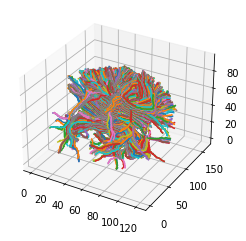

In [17]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')
for stream in new:
    x,y,z=get_points(stream)
    ax.plot(x,y,z)
plt.show()

In [18]:
point=get_max_point_and_min_point(new)

In [19]:
point

([122, 163, 97], [0, 0, 0])

In [21]:

import nibabel as nib

ni_img = nib.Nifti1Image(data, affine=np.eye(4))
nib.save(ni_img, "dicom_volume_image.nii")

In [96]:
new_matrix = np.zeros(shape=(123, 164, 98),dtype="float")

In [97]:
import random

for stream in new:
    for point in stream:
        new_matrix[tuple(point)]=random.uniform(1, 2)
    
    

In [98]:
for stream in new:
    for point in stream:
        print(new_matrix[tuple(point)])

1.0930717487815595
1.5575459393161366
1.5151742835084963
1.6750924216142993
1.1115439305674895
1.2649358049312536
1.2642243342362867
1.5575459393161366
1.5151742835084963
1.5195075551643518
1.6152375291195993
1.2649358049312536
1.2642243342362867
1.7451105075334112
1.946251007445293
1.6837290419114206
1.223447737289322
1.5596531082288116
1.425396316740208
1.499666689883901
1.7295790683448486
1.3917360200044908
1.718978175709032
1.1741937437544272
1.758945086551458
1.8340621128703911
1.8977208875880172
1.8826523564965436
1.6426473948173603
1.6066740747590562
1.1650558142508916
1.9725112454942366
1.6403262676038743
1.7999376638506828
1.426261033281079
1.54606537022793
1.048114679998895
1.2477831684809062
1.8057176811348121
1.148612618992046
1.0761431879401429
1.0573044860943834
1.4778672562089796
1.5647173865774575
1.2466715034655715
1.6227253181191053
1.15545020095202
1.148612618992046
1.0761431879401429
1.0573044860943834
1.6750924216142993
1.828930988700327
1.2466715034655715
1.622725

1.020172026242545
1.436462352500387
1.2717274181158662
1.8360024395867596
1.723409100887097
1.0677399430485668
1.6870163433152263
1.6870163433152263
1.768517616231457
1.2701754995160006
1.4898155512188702
1.5729382730769421
1.5755124257000674
1.4082567400271218
1.0858961684377366
1.8953631681631875
1.772990956414499
1.1970054629930016
1.1970054629930016
1.8506930432107485
1.7503575389523336
1.5380016142728654
1.4453930816481042
1.1477395820870346
1.2452099904048748
1.2443613672677103
1.2443613672677103
1.9503405647720362
1.79848799372268
1.79848799372268
1.563086753187547
1.9525199275189236
1.4768999651727903
1.5311852643030952
1.2692392099631962
1.9414380491826937
1.0517265942455936
1.0995648580242858
1.8462613312222191
1.8462613312222191
1.769950059510374
1.9943484284829052
1.5619531717341544
1.0196480224709468
1.6876679257549188
1.924570066532302
1.6398649034881059
1.4267875288173553
1.9196252852041749
1.802804995018112
1.9101912154486245
1.075988582137867
1.724660098383025
1.087320

1.6275443261348403
1.2110065845916331
1.37560485638789
1.1693186421566293
1.2690551576099902
1.7077882800772204
1.974209827054987
1.6319574043539173
1.4431951763046782
1.3935055639429508
1.2394277677584289
1.4372718131251792
1.2668019656906129
1.2068390187849376
1.484200590884083
1.9962797284474147
1.9962797284474147
1.871636961131955
1.2180782099978713
1.8910745211267042
1.38608861699656
1.6025622615047428
1.6354649591640615
1.7659759590802735
1.8030045785827542
1.7354241816198814
1.6881455361925517
1.0359821605887904
1.0359821605887904
1.7010060060962506
1.2648958710374418
1.8175009279977399
1.8587077526586517
1.855833143532878
1.7485224393427985
1.6150864375550287
1.1790644549868357
1.1790644549868357
1.3712730877518855
1.3573708110056462
1.3854536690340868
1.7980400695274152
1.9965127027721725
1.5136787311142352
1.6022511700587017
1.6022511700587017
1.5012521017551848
1.1319471371705148
1.9171620287686966
1.3977888927516142
1.5044915688305434
1.8714339326145542
1.5379500563671737
1

1.0787245026530687
1.2969701371722544
1.0461713471030416
1.174021883381685
1.8753825545350438
1.2496615769830133
1.2603627018523935
1.6902733140802297
1.6902733140802297
1.292064435037755
1.9922735992690792
1.9389253073855244
1.1975999542307056
1.2346835114513053
1.7066218787764544
1.7066218787764544
1.9309505876992028
1.1783266430178942
1.3429066699753025
1.6836477072150564
1.6743342500560938
1.5146869921198594
1.0657637182659205
1.1429510978330901
1.3336306955459376
1.3395767989605143
1.1340996566953656
1.756775916975546
1.5113745415412687
1.6140651466615068
1.8316879360350624
1.8316879360350624
1.2423188213299883
1.6423530489756433
1.751070947313334
1.793601962599286
1.2000284194546227
1.673436591206472
1.673436591206472
1.189240332013957
1.7236844008824752
1.0070153292879156
1.6057500325298486
1.227803383183426
1.3450333370030414
1.5974508028492467
1.3829525072529973
1.544633794564791
1.6916590343531601
1.3515132350604553
1.934529680195928
1.4579761663045334
1.307035502837562
1.659

1.0788450124341067
1.2628789989736853
1.218617242821225
1.636027655402078
1.7427943856709844
1.915708628902631
1.6556612797122763
1.874354297155247
1.460728807047912
1.8326196407133217
1.2343237862278773
1.9346639569107107
1.9998660815610698
1.445578778125408
1.4689212449769022
1.8564691573445251
1.033972104011212
1.033972104011212
1.8096704133008714
1.4176590344738838
1.0496270797191665
1.676326129735917
1.2017744579457044
1.2034354617878757
1.5928354843651906
1.6382867247274668
1.2803752200794456
1.437328578515365
1.6064192016512249
1.2928433368421248
1.6553315444664074
1.3227094774977395
1.2808444939724306
1.467042916242257
1.5994959306861847
1.577453339871432
1.2051812801113777
1.2051812801113777
1.9051794312411223
1.2778413873064172
1.5517953603141006
1.6163667797101502
1.5066150648288574
1.4809196745570472
1.8607129825267559
1.1644107861623905
1.956637798876772
1.0112057588023502
1.3333647433108866
1.8441009965483879
1.8441009965483879
1.9055356539381885
1.344984648999774
1.70274

1.6100538217694098
1.1133753686085188
1.9362238146097766
1.7516327146549913
1.5318411362432849
1.4181219792262176
1.129215438661102
1.6861775604900182
1.8731503458231562
1.2327223875557767
1.7876018576318828
1.479088851489573
1.149365170779797
1.988735672748795
1.2096079131842068
1.517969483149177
1.608583124100098
1.4556380086804759
1.9549447985700503
1.799171164038122
1.3924280143439756
1.9905766348934941
1.9905766348934941
1.2670787627433904
1.8709738408936958
1.4810237752242321
1.8569208883436148
1.701162911657382
1.1708528975892323
1.3356507945972291
1.1779872163751643
1.2881673213501164
1.8604715165522472
1.9614749061083134
1.3725039959387577
1.7946282657553772
1.1195926645192271
1.2014503901923421
1.9096384991038777
1.3470844394134582
1.1892826420041653
1.7960701560968508
1.4191421006559781
1.3557445443060516
1.4715549343330556
1.9884498102598824
1.0432651401458073
1.4069473903415326
1.498122762021152
1.7803169229441518
1.3031150343052444
1.4008917661112341
1.5329486628609321
1.

1.6374335504829318
1.3057646852748004
1.6484780887949486
1.922985887717784
1.8711335541472882
1.5781716941334585
1.381529364635472
1.0892496559222287
1.2913998047275586
1.619027517534711
1.624842011686594
1.28928214745031
1.1134750044979742
1.8266292518900296
1.4292753403371692
1.4791596847840327
1.0049494679814113
1.497242225581965
1.5923983220797022
1.8563955352398032
1.3194786695935465
1.7734398184072204
1.5626113509545472
1.2766950463174669
1.799198289795219
1.0018177166505482
1.6709431108163513
1.7140103900017514
1.383602990314626
1.383602990314626
1.5565744903959509
1.5346331088053988
1.064544186568487
1.8619112338370707
1.2339628503434048
1.5501046192958587
1.8989540305971753
1.2969913066861753
1.993614747934096
1.4648197441386481
1.79648883768313
1.1415779389650182
1.4430045669019815
1.8620363927955217
1.4352532382615355
1.4352532382615355
1.4406671281643364
1.792453422846255
1.8504823101028838
1.4403410581648828
1.4403410581648828
1.7002786639900613
1.1318180603511054
1.237164

1.9931470390370651
1.6345302524411474
1.6744727829592905
1.427007534250225
1.4999991498378225
1.4207791452127125
1.4967169049201239
1.6498488774298699
1.8749605419105178
1.3087961273447113
1.676556050485091
1.550496601697692
1.0586167395883688
1.3370818879017117
1.0953995014182512
1.7090271379259412
1.172235518150217
1.3570826319518141
1.2482627058552787
1.475044422783307
1.6859736540472894
1.2311945265314164
1.4586108807597444
1.786527781341513
1.3103731308437876
1.7024621010248864
1.6293639065508079
1.9452003735218795
1.3332870507237358
1.7528690749547589
1.5044649741291818
1.3726984065176828
1.3726984065176828
1.0890099539144746
1.4790106765170612
1.1113683372573662
1.5035583005429234
1.7267116574119614
1.9097011957880192
1.585267717123788
1.276482430560119
1.0269261249134454
1.799027031471189
1.3198252395351961
1.3027244179145
1.0669646019068448
1.0504781666299312
1.740952011759701
1.9561119534999842
1.645264896784183
1.0391262824461545
1.7723941751323764
1.6690488528564855
1.83437

1.4798761147445494
1.9544977471170224
1.82017369932629
1.82017369932629
1.710314270068189
1.8881481159476783
1.7006599883285454
1.6485526292242891
1.6485526292242891
1.6322662887033752
1.1789580334581702
1.8123415153353017
1.7444707485685353
1.687906768640393
1.7694832766423312
1.9254671645480892
1.6304092675299113
1.6905776006242357
1.3902716649430014
1.9287387612168678
1.0401915030891575
1.3230897541180524
1.075968022690664
1.8473705537613523
1.887070637352821
1.5362197580414465
1.6357732016060127
1.7656282893142201
1.7656282893142201
1.7290665766524929
1.1589899449040648
1.7182191084388496
1.03508594394087
1.371430391635588
1.8878682457600946
1.0056060884300138
1.318736016022192
1.4561140318182144
1.7666280890288673
1.8100266111135208
1.01518601151754
1.3429066699753025
1.352407855163741
1.8680054493366733
1.5593109232046056
1.4784785779844931
1.1429510978330901
1.3336306955459376
1.3395767989605143
1.7176054633426094
1.4062913096177587
1.5113745415412687
1.6140651466615068
1.694079

1.8071594284734656
1.4069149787933517
1.6164514476426532
1.7006848315635863
1.07595206914741
1.1218838393855275
1.2745998036702288
1.920893809230758
1.3178513085408612
1.8882289389739697
1.6891472654020103
1.841324786893987
1.518108845191771
1.6624913465586244
1.996694182447433
1.115523991047158
1.317140511933543
1.8460656781901328
1.052424456239017
1.0689886037897718
1.5352060984739775
1.5352060984739775
1.8965772735425521
1.9416716552286866
1.9878171531193218
1.7862678523488524
1.375494319219278
1.6416269804274908
1.5670558403721377
1.0851195875240802
1.6240011054292616
1.9180933791650254
1.9180933791650254
1.3940609237590693
1.489442354164523
1.8475588642600607
1.4209221313863392
1.1216658237159756
1.8763825149886124
1.2086894748680304
1.312943115078487
1.5321864318246647
1.932860775992548
1.932860775992548
1.701506465487394
1.2419499842951809
1.1480234683899135
1.6798491410626677
1.0437923406246568
1.9695287575465952
1.8285438838153076
1.8257694027510132
1.8257694027510132
1.088327

1.205659947902161
1.7219020792900377
1.6575856710847208
1.9493077265653236
1.1671556017796023
1.5283406182542816
1.3673472176652175
1.0305084003474332
1.688276287500649
1.4617202174912403
1.2465558615710215
1.329780441211423
1.4596299691913965
1.4988637483534677
1.8303943481851408
1.0522602775670127
1.0522602775670127
1.5816002843830859
1.4612612454083427
1.2475144797059
1.4793071323795686
1.2779111117979047
1.6676058744040632
1.616389562906751
1.6373474896755866
1.5027090805961938
1.9707667351282518
1.2762188272182708
1.9220560340313013
1.1121312056397263
1.1430450352761188
1.223219753971469
1.4889115127455494
1.7282164116690555
1.1953999411783855
1.0605561943054629
1.647824271656357
1.9932666331441413
1.452026682726125
1.5461335430324445
1.1909802803550447
1.2186256938740745
1.2730119314528205
1.8346705566176553
1.832507430292508
1.6660950305418887
1.1595585335335699
1.128441364139782
1.9279188493738213
1.2907678490719998
1.5308619884380148
1.6121971374873594
1.7463245249366826
1.795

1.8146707857819018
1.1780884524334179
1.075989481097296
1.3390417585932262
1.6735120531022336
1.6568950487558538
1.7807837697183113
1.8225523658794858
1.8917421404281782
1.300989909706354
1.3267725265772259
1.285575090674135
1.5407452867966287
1.4603277963612085
1.980143449223859
1.1705065262130088
1.343460305723729
1.5761039342450345
1.359698501156403
1.4259253470521562
1.3734521346596429
1.032812428643584
1.6947403850618563
1.6947403850618563
1.9162596974721264
1.6552481622051016
1.6552481622051016
1.0679097017600214
1.925466737340146
1.4081755016535211
1.883238744179239
1.455219462134351
1.208140321602827
1.964678962182401
1.743238867621502
1.2699659672813395
1.8619692275911102
1.0792854545057888
1.4782076470589438
1.4774526109423451
1.0304815712385653
1.0797708254052716
1.2022469821058803
1.2022469821058803
1.2646126546612892
1.2142581037367413
1.224392024290749
1.5761039342450345
1.5595518612727863
1.1705065262130088
1.980143449223859
1.4603277963612085
1.5407452867966287
1.259743

1.4919937446494431
1.855221716715485
1.0018649113319398
1.454888792670928
1.177168434287148
1.2038043883295502
1.1695551262216217
1.6566456455788556
1.2424606313069568
1.1424656108836402
1.2018615883442831
1.9698179835069638
1.120483964554469
1.867366479990034
1.5811245287047926
1.256494611076434
1.1646888681760417
1.1646888681760417
1.0405377512824432
1.2347869137118348
1.8645756550313397
1.7502740218142145
1.19654073779521
1.1059489939212352
1.393826611164823
1.1767875706153081
1.143347471436242
1.2662353515611433
1.884866367770908
1.2481019894109109
1.920951307117123
1.034802756124503
1.598484697683863
1.5342486662820187
1.271559088037359
1.8146707857819018
1.6968216186933167
1.8772836461006834
1.884737061668363
1.2217815796411724
1.506689632482621
1.9558255072240471
1.523233842357178
1.523233842357178
1.452679920034744
1.951189098712022
1.4160573530092522
1.7093634160138742
1.1346170095042962
1.2959625402522166
1.1011488019776294
1.6634739366076254
1.5786923771404076
1.405458715262

KeyboardInterrupt: 

In [92]:
random.uniform(1, 2)

1.172834774994699

In [93]:
new_matrix

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [100]:
import nibabel as nib

ni_img = nib.Nifti1Image(new_matrix, affine=np.eye(4))
nib.save(ni_img, "dicom_volume_image_nuevo.nii")